<a href="https://colab.research.google.com/github/i-was-here/summer-intern-tasks-iitgn/blob/main/Task3_SRIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries :-

In [162]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import jit, vmap, pmap, grad
from jax import random
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from jax import value_and_grad
import matplotlib.pyplot as plt

In [163]:
# No. of neurons in each of the two hidden layers

hidden_l1 = 512
hidden_l2 = 256

Model Definition :-

In [164]:
# Definition of Model-Layers

def model_layers(layers, ini_key):
  more_keys = random.split(ini_key, num=len(layers)-1)
  parameters = []
  factor = 0.01
  for incoming_neurons, outgoing_neurons, each_key in zip(layers[:-1], layers[1:], more_keys):
    each_key1, each_key2 = random.split(each_key)
    parameters.append([jax.random.normal(each_key1, shape=(outgoing_neurons, incoming_neurons))*factor, jax.random.normal(each_key2, shape=(outgoing_neurons,))*factor])
  return parameters

In [165]:
# Sample model :-

key = jax.random.PRNGKey(0)
model_pars = model_layers([784, hidden_l1, hidden_l2, 10], key)
print(jax.tree_map(lambda x: x.shape, model_pars))

[[(512, 784), (512,)], [(256, 512), (256,)], [(10, 256), (10,)]]


In [166]:
# Definition of Predict function for SINGLE Image

def predict(parameters, x):

  hidden_layers = parameters[:-1]
  activation = x

  for w, b in hidden_layers:
    activation = jax.nn.relu(jnp.dot(w, activation) + b)

  # we predict the probability of image to be in each class using log-softmax loss function
  w_last, b_last = parameters[-1]
  log_e_sum = jax.scipy.special.logsumexp(jnp.dot(w_last, activation) + b_last)
  
  return jnp.dot(w_last, activation) + b_last - log_e_sum

In [167]:
# Predict function of Batch of images using "vmap" function

batched_predict = vmap(predict, in_axes=(None, 0))

Input Dataset(MNIST) :-

In [168]:
# Some relevant functions needed for dataset input :-

def torch_transform(inp):
  """Transform function for input images"""
  return np.ravel(np.array(inp, dtype=np.float32))

def our_collate(batch):
  """Collate function to combine data together in required format"""
  zipped_data = list(zip(*batch))
  images = np.array(zipped_data[0])
  labels = np.array(zipped_data[1])
  return images, labels

In [169]:
# Data download and loading

train_data = MNIST("train_data", True, torch_transform, download=True)
test_data = MNIST("test_data", False, torch_transform, download=True)

loaded_data_train = DataLoader(train_data, batch_size=128, shuffle = True, collate_fn=our_collate, drop_last=True)
loaded_data_test = DataLoader(test_data, batch_size=128, shuffle = True, collate_fn=our_collate, drop_last=True)

Training of Model

In [170]:
# Important functions used while training the model :-

def loss(params, imgs, lbls):
  """LOG-SOFTMAX"""
  # Labels are to be one hot encoded before sending here
  predictions = batched_predict(params, imgs)
  return -jnp.mean(predictions*lbls)

def update(params, imgs, lbls):
  """Updating of parameters using Gradient Descent using 'PyTree' Concept"""
  # Labels are to be one hot encoded before sending here
  losses, grads = value_and_grad(loss)(params, imgs, lbls)
  return losses, jax.tree_multimap(lambda p, g: p-0.001*g, params, grads)

def accuracy(pars, loader):
  """Percentage of correct prediction out of total number of images"""
  acc_val = 0
  for img, lbl in loader:
    predictions = jnp.argmax(batched_predict(pars, img), axis = 1)
    acc_val += np.sum(predictions == lbl)
  return acc_val/(len(loader)*loader.batch_size)

In [171]:
# Model Training :-

key = jax.random.PRNGKey(0)

hidden_l1 = 512
hidden_l2 = 256

model_pars = model_layers([784, hidden_l1, hidden_l2, 10], key)

no_epochs = 10

losses_per_batch = []
Xaxis = []
index_batch = 1

for epoch in range(no_epochs):
  ind = 0
  for images, labels in loaded_data_train:
    one_hot_encoded_labels = jax.nn.one_hot(labels, len(MNIST.classes))
    losses, model_pars = update(model_pars, images, one_hot_encoded_labels)
    if ind%200 == 0:
      print("Loss after every 200 images : "+str(losses))
      losses_per_batch.append(losses)
      Xaxis.append(index_batch)
      index_batch += 1
    ind += 1
  print(f'After epochs {epoch}, test_acc = {accuracy(model_pars, loaded_data_test)}, train_acc = {accuracy(model_pars, loaded_data_train)}')

Loss after every 200 images : 0.2410496
Loss after every 200 images : 0.16515613
Loss after every 200 images : 0.10421449
After epochs 0, test_acc = 0.8137019276618958, train_acc = 0.8026843070983887
Loss after every 200 images : 0.106612824
Loss after every 200 images : 0.08037942
Loss after every 200 images : 0.06668167
After epochs 1, test_acc = 0.8636819124221802, train_acc = 0.8535490036010742
Loss after every 200 images : 0.05265942
Loss after every 200 images : 0.05220306
Loss after every 200 images : 0.039586045
After epochs 2, test_acc = 0.8848156929016113, train_acc = 0.8742654919624329
Loss after every 200 images : 0.044206627
Loss after every 200 images : 0.03868633
Loss after every 200 images : 0.0324692
After epochs 3, test_acc = 0.8956330418586731, train_acc = 0.8872696161270142
Loss after every 200 images : 0.050922967
Loss after every 200 images : 0.037214216
Loss after every 200 images : 0.032906722
After epochs 4, test_acc = 0.9018429517745972, train_acc = 0.89508211

Plot of Loss vs. Iterations :-

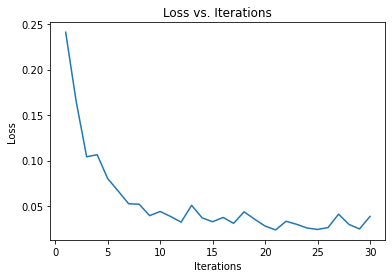

In [174]:
plt.plot(Xaxis, losses_per_batch)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs. Iterations")
plt.show()